
#### učitavanje podataka (https://www.kaggle.com/datasets/kandij/mall-customers )

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Mall_Customers.csv')

#### pregled početnih podataka, atributi: "AnnualIncome" i SpendingScore

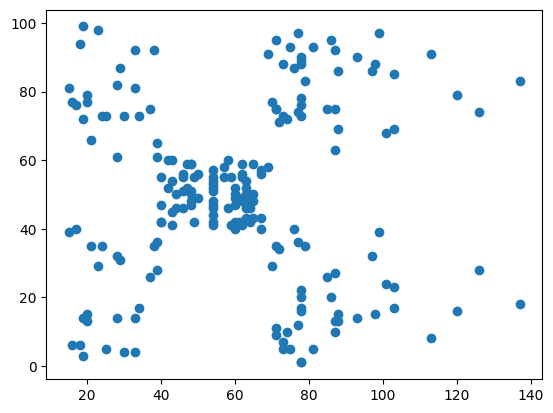

In [18]:
plt.scatter(df.AnnualIncome, df.SpendingScore)

## Algoritam 1: DBSCAN

In [19]:
from matplotlib.colors import ListedColormap
import numpy as np

In [20]:
df_2 = df[['AnnualIncome','SpendingScore']]


def euc_dist(p1,p2):  
    return np.sqrt(np.sum(np.square(p1 - p2)))

# matrica koja sadrži sve udaljenosti točaka
def matrix_distances(df, atr1, atr2):
    matrix = []
    for i1, j1 in zip(df[atr1].values, df[atr2].values):
        temp = []
        for i2, j2 in zip(df[atr1].values, df[atr2].values):
            temp.append(euc_dist(np.array([i1, j1]), np.array([i2, j2])))
        matrix.append(temp)

    return matrix


def categorize_points(point_index, radius, minBr, matrix):
    
    counter = -1
    for i in range(len(matrix[point_index])):
        if matrix[point_index][i] <= radius:
            counter += 1

    if counter >= minBr: return 1
    elif counter > 0  and counter < minBr: return 2
    elif counter == 0: return 3

        
# prvi korak
def inital_point_categorized(matrix, radius, minBr):

    categories = []
    for i in range(len(matrix)):
        cat = categorize_points(i, radius, minBr, matrix)
        categories.append(cat)
                
    for i in range(len(categories)):
        if categories[i] == 2:
            cat_1_counter = 0
            for j in range(len(matrix)):
                if categories[j] == 1 and matrix[i][j] <= radius:
                    cat_1_counter = cat_1_counter + 1
            if cat_1_counter == 0:
                categories[i] = 3   
    return categories

# drugi korak
def second_categorization(matrix, categories, radius):
    clusters = []
    for i in matrix:
        clusters.append(-1)
    cluster_counter = 0
    for n_idx in range(len(categories)):
       if categories[n_idx] == 3:
           clusters[n_idx] = 0
       break_term = False
    while break_term == False:
        for init_core_index in range(len(categories)):
            if categories[init_core_index] == 1 and clusters[init_core_index] == -1:
                add_points = []
                cluster_counter = cluster_counter + 1
                add_points.append(init_core_index)
                clusters[add_points[0]] = cluster_counter
                while add_points:
                    for point_idx in range(len(matrix[add_points[0]])):
                        clusters[add_points[0]] = cluster_counter
                        if matrix[add_points[0]][point_idx] <= radius and matrix[add_points[0]][point_idx] > 0:
                            if clusters[point_idx] == -1 and categories[point_idx] == 1:
                                add_points.append(point_idx)
                            if clusters[point_idx] == -1 and categories[point_idx] == 2:
                                clusters[point_idx] = cluster_counter
                        
                    add_points.pop(0)
            else: break_term = True
    for cl_ind in range(len(clusters)):
        if clusters[cl_ind] == -1:
            clusters[cl_ind] = 0
           
    return clusters
                        


Graf nakon prvog koraka

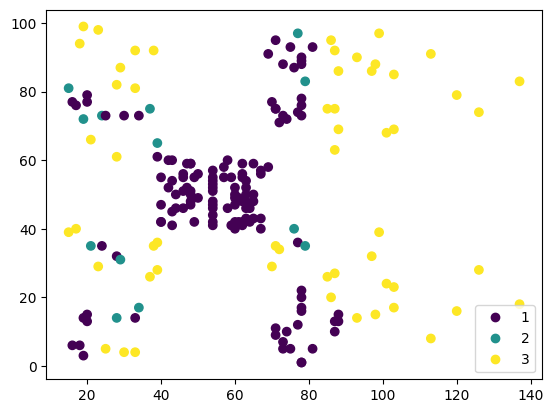

In [21]:

df_2 = df[['AnnualIncome','SpendingScore']]

radius_defined = 5
minBr_defined = 3

inital_categories = inital_point_categorized(matrix_distances(df_2, 'AnnualIncome','SpendingScore'),
                radius_defined, minBr_defined-1)
colors = ListedColormap(['#1380a8', '#c4861a', '#851869','#3c90af'])
scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=inital_categories)

plt.legend(*scatter.legend_elements())
plt.show()


Graf nakon drugog koraka

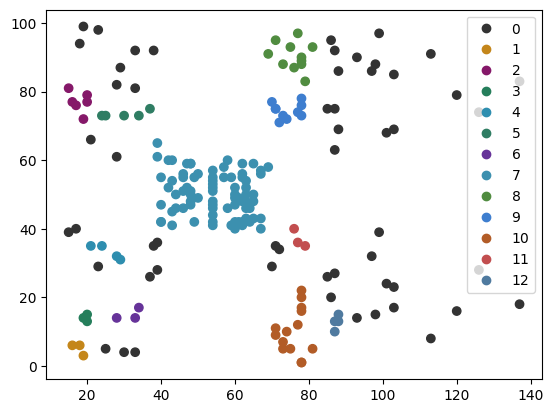

In [22]:
inital_categories = inital_point_categorized(matrix_distances(df_2, 'AnnualIncome','SpendingScore'),
                radius_defined, minBr_defined-1)

second_categories = second_categorization(matrix_distances(df_2, 'AnnualIncome','SpendingScore'),
                inital_categories, radius_defined)


colors = ListedColormap(['#333333',
    '#c4861a','#bb6b40','#851869','#5d8aa8','#257e5b','#2e8eaf','#c34f55',
    '#2f7d63','#9b59b6','#663399','#3c90af','#aa4d89','#508c40','#d35400','#3e7ecf','#b25c27','#d35400','#c24e4f',
    '#4f7a9f'])
scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=second_categories, cmap=colors)

plt.legend(*scatter.legend_elements())
plt.show()



## Algoritam 2: Aglomerativno hijerarhijsko grupiranje

In [23]:

# povezivanje prema minimalnoj udaljenosti
def single_linkage(matrix, positions,minimum):
    for i in range(len(matrix)):
        if matrix[positions[1]][i] < matrix[positions[0]][i] and matrix[positions[1]][i] != 0.0:
            matrix[positions[0]][i] = matrix[positions[1]][i]
            matrix[i][positions[0]] = matrix[i][positions[1]]
            
    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    matrix.remove(matrix[positions[1]])
        
    return matrix, positions, minimum

# povezivanje prema maksimalnoj udaljenosti
def complete_linkage(matrix, positions,minimum):
    for i in range(len(matrix)):
        if i != positions[1] and i != positions[0]:
            matrix[positions[0]][i] = max(matrix[positions[0]][i],matrix[positions[1]][i])
            matrix[i][positions[0]] = max(matrix[positions[0]][i],matrix[positions[1]][i])

    for i in range(len(matrix)):
        matrix[i].pop(positions[1])
    matrix.remove(matrix[positions[1]])

    return matrix, positions, minimum


# pronalazak trenutne najmanje/najveće udaljenosti u matrici i njene pozicije
def value_matrix(matrix, linkage):

    dict = {}
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] != 0.0:  
                dict[(i,j)] = matrix[i][j]

    current = min(dict.values())
    for key, value in dict.items():
        if value == current:

            key_found = key
            break 
    if linkage == 'single':
        return single_linkage(matrix, key_found,current)    
    if linkage == 'complete':
        return complete_linkage(matrix, key_found,current)  
    

def flatten(lst):
    flattened_list = []
    for item in lst:
        if isinstance(item, list):
            flattened_list.extend(flatten(item))
        else:
            flattened_list.append(item)
    return flattened_list

#spajanje skupina u matrici
def matrix_minimization(matrix, linkage):
    clusters = []
    minimums = []
    matrix_mod = matrix

    borders = []
    for i in range(len(matrix)):
        borders.append(i)
    for _ in range(len(matrix) -1):
        
        matrix_mod, positions, minimum = value_matrix(matrix_mod, linkage)
        if type(borders[positions[0]]) == list:
            for i in borders[positions[0]]:
                if type(i) == list:
                    borders[positions[0]] = flatten(borders[positions[0]])
        if type(borders[positions[1]]) == list:
            for i in borders[positions[1]]:
                if type(i) == list:
                    borders[positions[1]] = flatten(borders[positions[1]])    
                         
        borders[positions[0]] =flatten([borders[positions[0]],borders[positions[1]]])
        
        borders.pop(positions[1])
        
        clusters.append(borders[positions[0]])
        minimums.append(minimum)
    return clusters, minimums


def normalize(categories):
    counter = 1
    mapping = {}
    for i in range(len(categories)):
        if categories[i] != 0 and categories[i] not in mapping:
            mapping[categories[i]] = counter
            categories[i] = counter
            counter += 1
        elif categories[i] != 0 and categories[i] in mapping:
            categories[i] = mapping[categories[i]]
    return categories
            

def final_clusters(n,clusters,minimums,break_point):

    clusters_final = []
    for i in range(n):
        clusters_final.append(0)
    clusters_up_to_now = []
    for idx in range(len(minimums)):
        if minimums[idx] <= break_point:
            clusters_up_to_now.append(clusters[idx])
        if minimums[idx]  > break_point:
            break
    
    cluster_counter = 0
    for cl in clusters_up_to_now:
        cluster_counter += 1
        for c in cl:
            clusters_final[c] = cluster_counter
    
    return normalize(clusters_final)


In [24]:
#kreiranje dendograma
def dendogram(clusters, minimums):
    dendrogram_data = []
    clusters_up_to_now = []
    for idx in range(len(clusters)):
        
        temp = []
        if len(clusters[idx]) == 2:
            temp.append(clusters[idx][0])
            temp.append(clusters[idx][1])
            
            clusters_up_to_now.append(clusters[idx])
            
        else:
            subset_found = False
            for sublist in clusters_up_to_now:
                if (set(sublist).issubset(set(clusters[idx]))):
                    subset_found = True
                    subset = sublist
                    clusters_up_to_now.remove(sublist)
                    clusters_up_to_now.append(clusters[idx])
                    break
            
            subset_found2 = False
            for sublist2 in clusters_up_to_now:
                if (set(sublist2).issubset(set(clusters[idx]))) and sublist2 != clusters[idx]:
                    subset_found2 = True
                    subset2 = sublist2
                    clusters_up_to_now.remove(sublist2)
                    break

            if subset_found2 == True:
 
                position = clusters.index(subset) + len(minimums) +1
                position2 = clusters.index(subset2) + len(minimums)  +1
                temp.append(position)
                temp.append(position2)
                
            elif subset_found == True:
                new_elements = next(iter(set(clusters[idx]) - set(subset)))
                position = clusters.index(subset) + len(minimums) +1
                temp.append(min(new_elements, position))
                temp.append(max(new_elements, position))


        temp.append(minimums[idx])
        temp.append(len(clusters[idx]))
        
        dendrogram_data.append(temp)

    return dendrogram_data

Graf s metodom povezivanje minimalnom udaljenosti

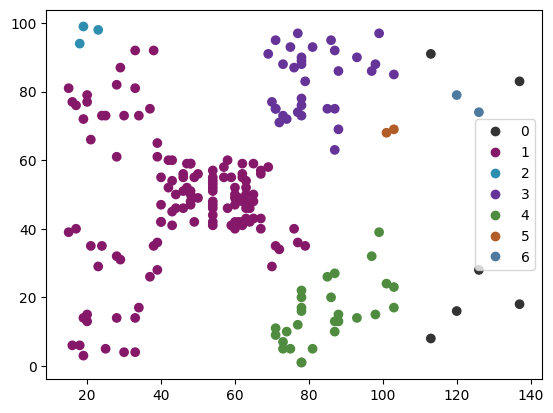

In [25]:
colors = ListedColormap(['#333333',
    '#c4861a','#bb6b40','#851869','#5d8aa8','#257e5b','#2e8eaf','#c34f55',
    '#2f7d63','#9b59b6','#663399','#3c90af','#aa4d89','#508c40','#d35400','#3e7ecf','#b25c27','#d35400','#c24e4f',
    '#4f7a9f'])
break_point = 10

matrix_ah = matrix_distances(df_2, 'AnnualIncome','SpendingScore')
n = len(matrix_ah)
clusters,minimums = matrix_minimization(matrix_ah,'single')

dendrogram_data = dendogram(clusters, minimums)

final_cl = final_clusters(n,clusters,minimums,break_point)

scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=final_cl, cmap=colors)

plt.legend(*scatter.legend_elements())
plt.show()

pripadni dendrogram

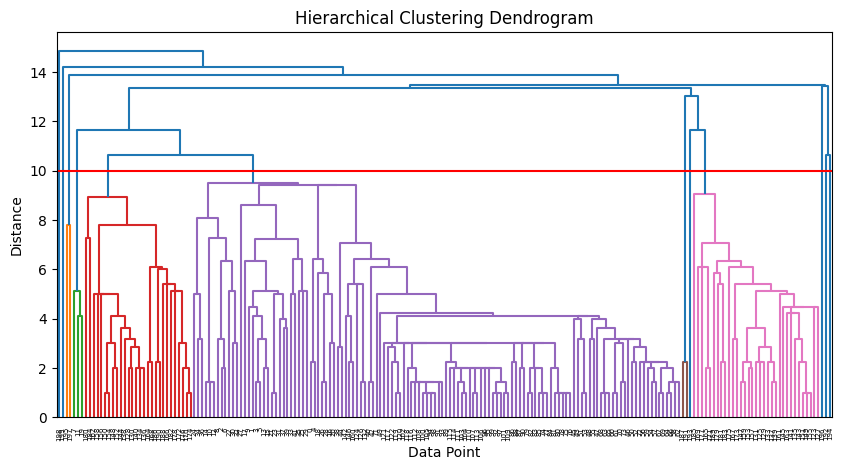

In [26]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(dendrogram_data, labels=np.arange(0, len(df_2)))
plt.axhline(y=break_point, color='r')
plt.show()

Graf s metodom povezivanje maksimalnom udaljenosti

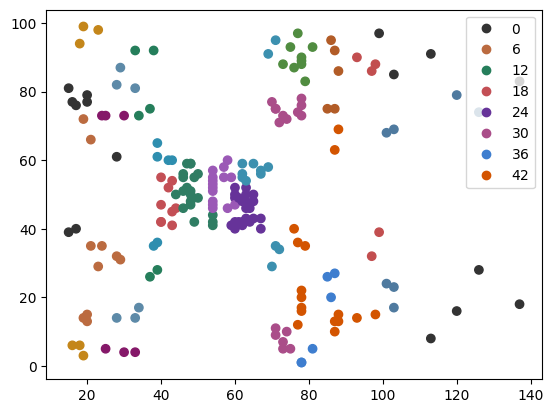

In [27]:
colors = ListedColormap(['#333333',
    '#c4861a','#bb6b40','#851869','#5d8aa8','#257e5b','#2e8eaf','#c34f55',
    '#2f7d63','#9b59b6','#663399','#3c90af','#aa4d89','#508c40','#d35400','#3e7ecf','#b25c27','#d35400','#c24e4f',
    '#4f7a9f'])
break_point_2 = 10

matrix_ah_2 = matrix_distances(df_2, 'AnnualIncome','SpendingScore')
n_2 = len(matrix_ah_2)
clusters_2,minimums_2 = matrix_minimization(matrix_ah_2,'complete')

dendrogram_data_2 = dendogram(clusters_2, minimums_2)
final_cl_2 = final_clusters(n_2,clusters_2,minimums_2,break_point_2)
scatter_2 = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=final_cl_2, cmap=colors)

plt.legend(*scatter_2.legend_elements())
plt.show()

pripadni dendrogram

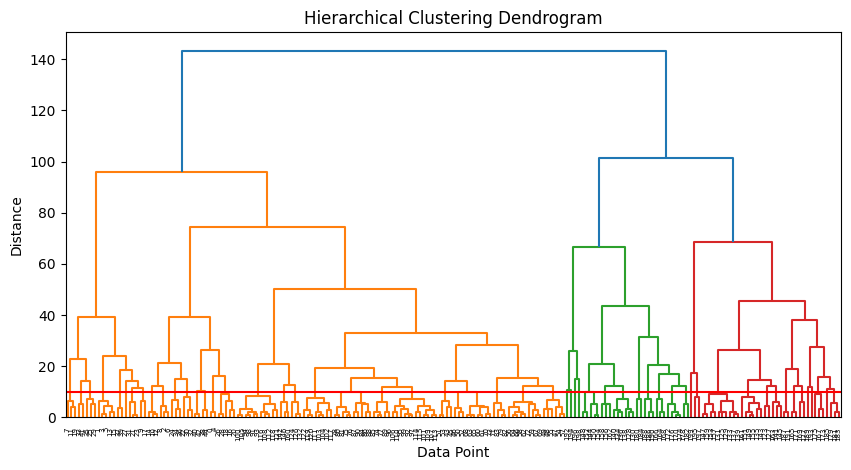

In [28]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(dendrogram_data_2, labels=np.arange(0, len(df_2)))
plt.axhline(y=break_point_2, color='r')
plt.show()



## Algoritam 3: Algoritam srednjeg pomaka

In [29]:


def update_points(data):
    updated_data = []
    for i in range(len(data)):
        sum_1 = [0,0]
        sum_2 = [0,0]
        for j in range(len(data)):
            sum_1[0] += data[j][0]*np.exp(-0.5 * (euc_dist(np.array(data[i]), np.array(data[j])) ** 2) / (bandwidth ** 2))
            sum_1[1] += data[j][1]*np.exp(-0.5 * (euc_dist(np.array(data[i]), np.array(data[j])) ** 2) / (bandwidth ** 2))

            sum_2[0] += np.exp(-0.5 * (euc_dist(np.array(data[i]), np.array(data[j])) ** 2) / (bandwidth ** 2))
            sum_2[1] += np.exp(-0.5 * (euc_dist(np.array(data[i]), np.array(data[j])) ** 2) / (bandwidth ** 2))
        result = [sum_1[i] / sum_2[i] for i in range(len(sum_1))]
        for i in range(len(result)):
            result[i] = round(result[i],0)
        updated_data.append(result)
    return updated_data
        
def categorize_data(data):
    categories = {}
    for d in data:
        if tuple(d) not in categories.keys():
            categories[tuple(d)] = len(categories)
    clusters = []
    for d in data:
        clusters.append(categories[tuple(d)])
    return clusters



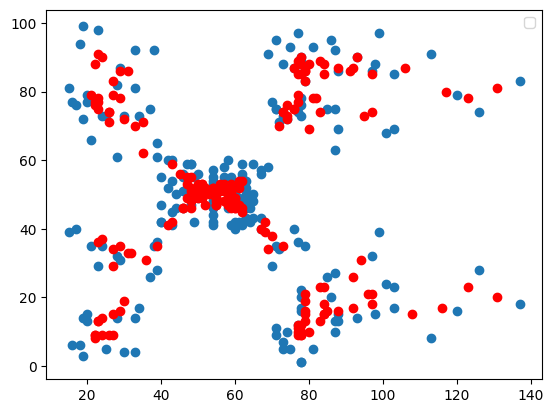

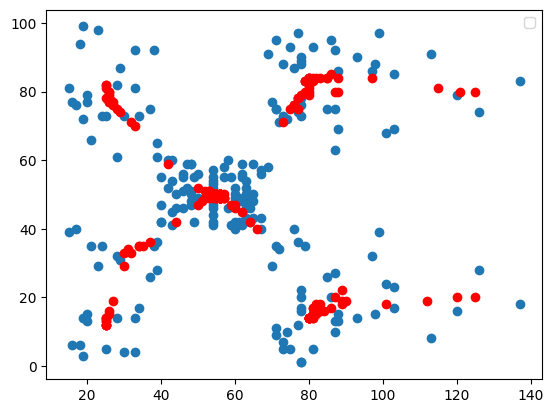

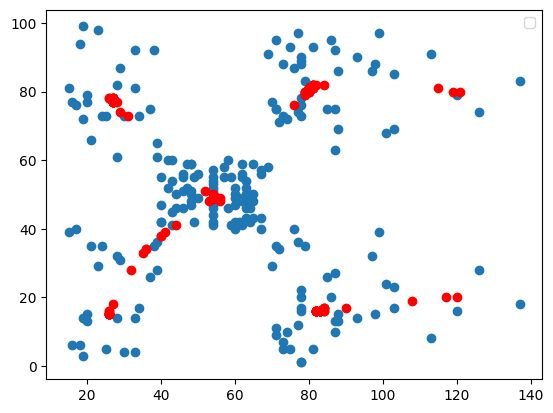

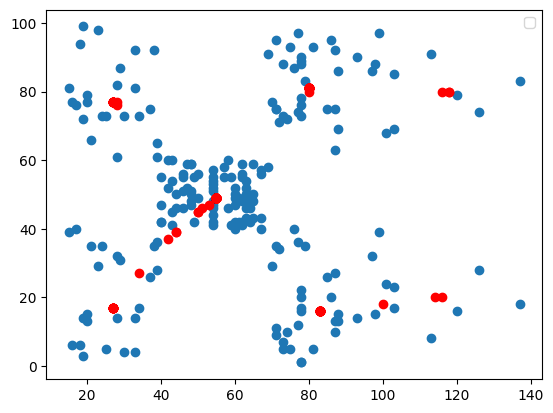

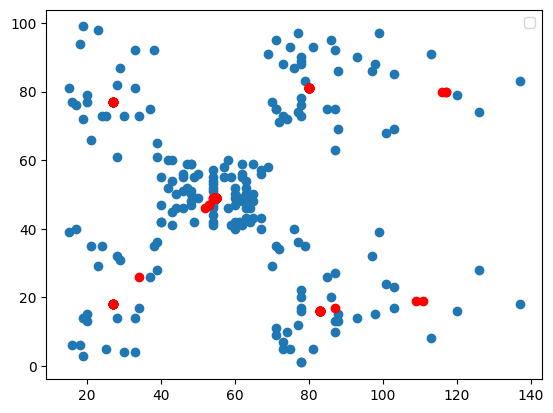

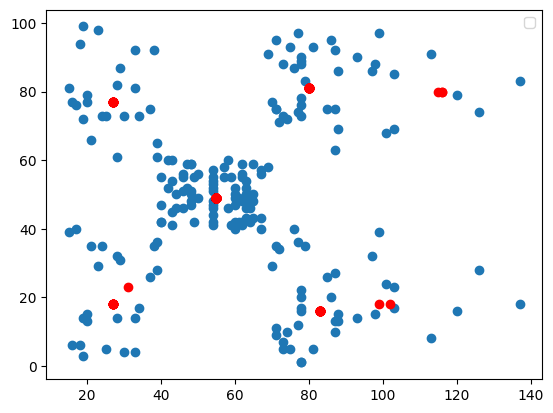

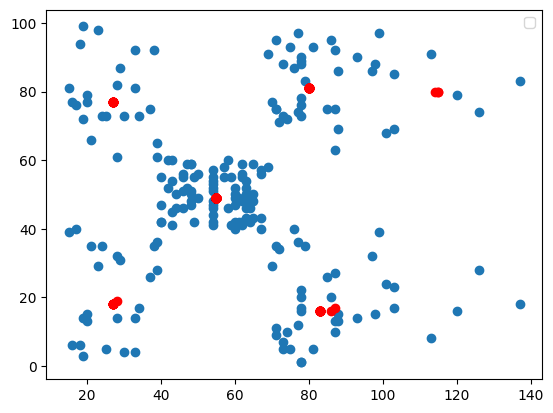

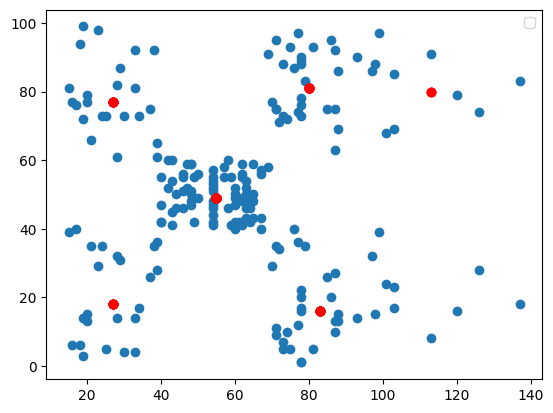

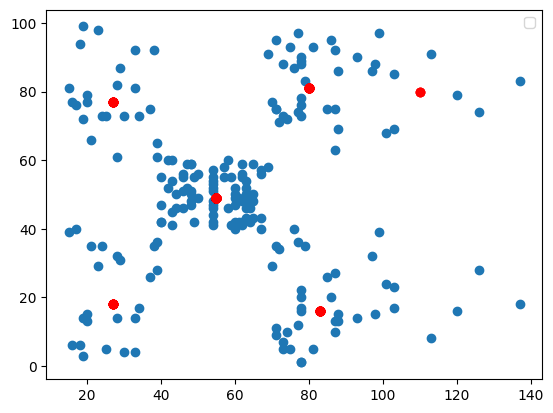

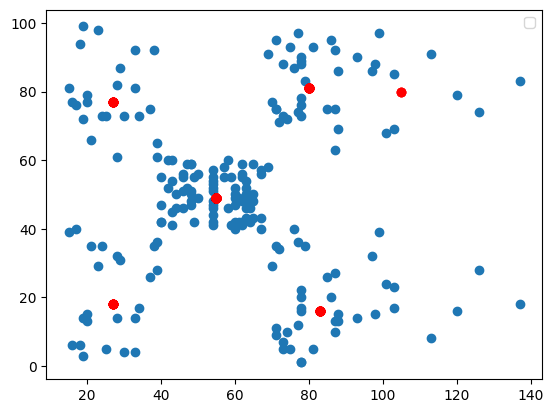

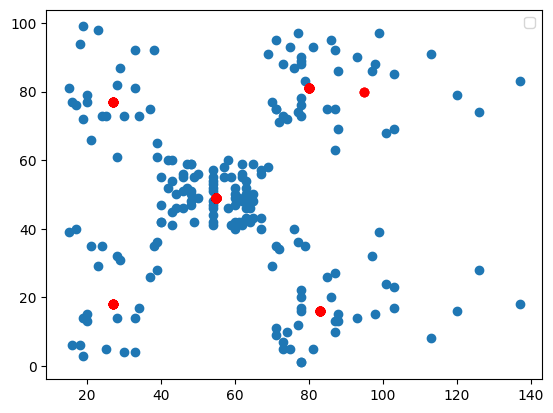

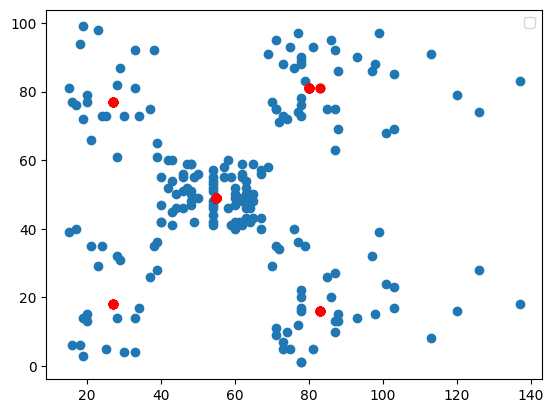

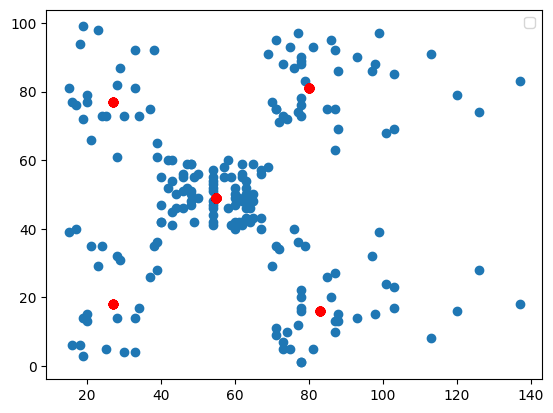

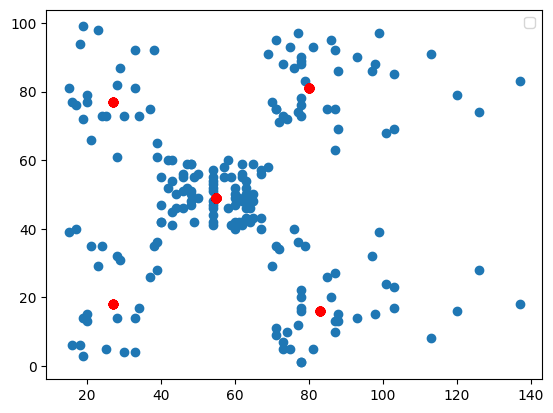

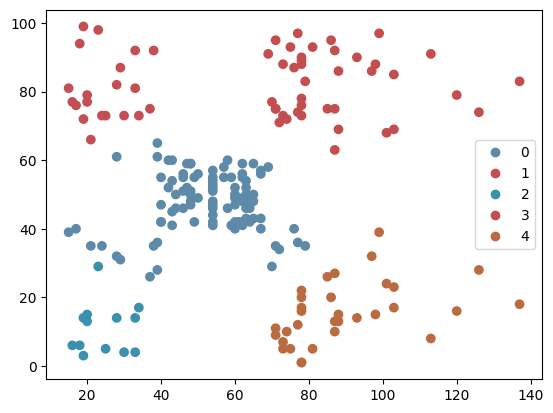

In [31]:
data = df_2.values.tolist()

bandwidth = 10.5
counter = 0
stop = False
while stop == False:
    data_prev = data.copy()
    data = update_points(data)

    if data == data_prev:
        stop = True 
        
    for d in data:
        plt.plot(d[0],d[1],'ro') 

    scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore)

    plt.legend(*scatter.legend_elements())
    plt.show()
    counter = counter + 1	


clusters_ms = categorize_data(data)

colors = ListedColormap([
'#5d8aa8','#257e5b','#2e8eaf','#c34f55',
'#2f7d63','#9b59b6','#663399','#3c90af','#3e7ecf','#851869','#c24e4f','#aa4d89',
'#4f7a9f','#bb6b40'])
scatter = plt.scatter(df_2.AnnualIncome, df_2.SpendingScore, c=clusters_ms, cmap=colors)

plt.legend(*scatter.legend_elements())
plt.show()